In [5]:
import numpy as np 
import pandas as pd
import librosa 
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import math
import os
import torch 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [8]:
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")
taxo_df = pd.read_csv("/kaggle/input/birdclef-2025/taxonomy.csv")

In [9]:
df = train_df[["primary_label", "filename", "scientific_name"]].copy()

In [10]:
df = df.sort_values(by="primary_label")

In [11]:
prim_class_ = taxo_df.set_index('primary_label')['class_name'].to_dict()

In [12]:
df['label'] = df['primary_label'].astype(str).map(prim_class_) + '_' + df['primary_label'].astype(str)  

In [13]:
df.head()

,primary_label,filename,scientific_name,label
0,1139490,1139490/CSA36385.ogg,Ragoniella pulchella,Insecta_1139490
1,1139490,1139490/CSA36389.ogg,Ragoniella pulchella,Insecta_1139490
2,1192948,1192948/CSA36358.ogg,Oxyprora surinamensis,Insecta_1192948
3,1192948,1192948/CSA36366.ogg,Oxyprora surinamensis,Insecta_1192948
4,1192948,1192948/CSA36373.ogg,Oxyprora surinamensis,Insecta_1192948


In [14]:
class Config:
    out_dir = "/kaggle/working/"
    in_dir = "/kaggle/input/birdclef-2025/train_audio/"
    fs = 32000

    n_fft = 1024
    hop_length = 256
    n_mels = 64
    fmin = 50
    fmax = 12000

    target_dur = 5
    target_shape = (256, 256)

config = Config()

Amphibia_126247


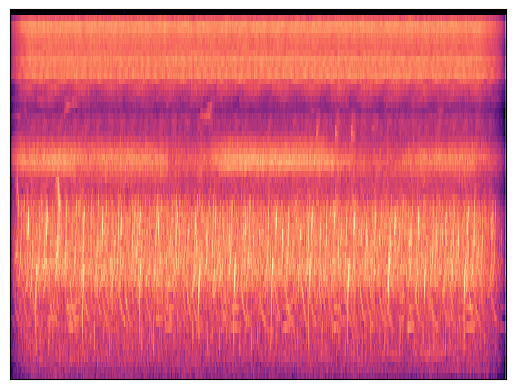

In [13]:
import IPython.display as ip
audio_ = config.in_dir+df.filename[10]
label = df.label[10]
print(label)
ip.Audio(audio_)
y, sr = librosa.load(config.in_dir + df.filename[10])
mel_spec_test = librosa.feature.melspectrogram(
    y=y, 
    sr=sr,
    n_fft=config.n_fft,
    hop_length=config.hop_length,
    n_mels=config.n_mels,
    fmin=config.fmin,
    fmax=config.fmax,
)
mel_db = librosa.power_to_db(mel_spec_test, ref=np.max)
librosa.display.specshow(mel_db)
plt.show()

In [14]:
def audio2mel(audio_):
    if np.isnan(audio_).any():
        mean_ = np.nanmean(audio_)
        audio_ = np.nan_to_num(audio_, nan = mean_)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_,
        sr=config.fs,
        n_fft=config.n_fft,
        hop_length=config.hop_length,
        n_mels=config.n_mels,
        fmin=config.fmin,
        fmax=config.fmax,
        power=2.0
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-8)
    return mel_db

In [15]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    audio_, _  = librosa.load(config.in_dir + row.filename, sr=config.fs)
    target_samp = int(config.target_dur * config.fs)

    if len(audio_) < target_samp:
        n_copy = math.ceil(target_samp/len(audio_))
        if n_copy > 1:
            audio_ = np.concatenate([audio_] * n_copy)
    start = max(0, int(len(audio_)/2 - target_samp/2))
    end = min(len(audio_), start+target_samp)

    audio_ = audio_[start:end]
    if len(audio_) < target_samp:
        audio_ = np.pad(audio_, (0, target_samp - len(audio_)), mode='constant')
    mel_spec = audio2mel(audio_)
    if mel_spec.shape != config.target_shape:
        mel_spec = cv.resize(mel_spec, config.target_shape, interpolation=cv.INTER_LINEAR)

    out_path = f"{config.out_dir}{row.label}_{i}.npy"
    np.save(out_path, mel_spec.astype(np.float32))

100%|██████████| 28564/28564 [31:43<00:00, 15.01it/s]  


In [3]:
! ls | head -2

Amphibia_126247_10.npy
Amphibia_126247_11.npy
ls: write error: Broken pipe


In [22]:
class BirdClefDs(Dataset):
    def __init__(self,mel_dir, transform=None):
        self.mel_dir = mel_dir
        self.transform = transform
        
        self.files = [f for f in os.listdir(mel_dir) if f.endswith(".npy")]
        labels_id = sorted(set([f.split('_')[1] for f in self.files]))
        self.class_id = {label:id_ for id_, label in enumerate(labels_id)}
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, id_):
        filename = self.files[id_]
        filepath = os.path.join(self.mel_dir, filename)

        img = np.load(filepath).astype(np.float32)
        if img.ndim == 2:
            img = np.expand_dims(img, axis = 0)
        img = torch.from_numpy(img)
        label = self.class_id[filename.split('_')[1]]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [23]:
BirdClef = BirdClefDs(config.out_dir)
for i, (sample, label) in enumerate(BirdClef):
    print(f"{i}: {sample.size()}, {label}")

In [24]:
class_label_map

{}

In [26]:
batch_size=64
BirdClef_train = DataLoader(BirdClef, batch_size=batch_size, shuffle=True, num_workers=4)

In [29]:
for x, y in BirdClef_train:
    print(f"{x.shape} : {y.shape}")
    break

torch.Size([64, 1, 256, 256]) : torch.Size([64])


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'